## experimentation with plotly and goodfire SDK to find some knoledge in the data

In [1]:
from utils.parse_csv import parse_csv
import pandas as pd
from ember_answers import ember_answers
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import goodfire
from dotenv import load_dotenv
import os

load_dotenv()
GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")
client = goodfire.Client(api_key=GOODFIRE_API_KEY)

In [2]:
datas = parse_csv()
ember_answers = ember_answers

In [3]:
datas.head()

,user_name,user_description,tweet,state,vote_prediction
0,El Sol Latino News,🌐 Noticias de interés para latinos de la costa...,#Elecciones2020 | En #Florida: #JoeBiden dice ...,Florida,Neutral
1,Tgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,"Usa 2020, Trump contro Facebook e Twitter: cop...",NaN,Trump
2,snarke,"Will mock for food! Freelance writer, blogger,...","#Trump: As a student I used to hear for years,...",Oregon,Trump
3,Trumpytweeter,"If he doesn't tweet for some time, should we b...",2 hours since last tweet from #Trump! Maybe he...,NaN,Trump
4,Rana Abtar - رنا أبتر,"Washington Correspondent, Lebanese-American ,c...",You get a tie! And you get a tie! #Trump ‘s ra...,District of Columbia,Trump


In [4]:
datas["llama_pred"] = ember_answers

In [5]:
datas.head()
variant = goodfire.Variant("meta-llama/Llama-3.3-70B-Instruct")

In [6]:
print('data.len', len(datas))

data.len 483


In [7]:
FEATURE_COMPUTE_SIZE=15
trump = datas[datas["vote_prediction"] == "Trump"]
biden = datas[datas["vote_prediction"] == "Biden"]
neutral = datas[datas["vote_prediction"] == "Neutral"]
print(len(trump), len(biden), len(neutral))

261 182 40


In [8]:
positive_news_features, negative_news_features = client.features.contrast(
	dataset_1=[
		[
			{
				"role": "user",
				"content": f"\"{text}\"",
			},
			{"role": "assistant", "content": "Trump"},
		]
		for text in trump[60:60 + FEATURE_COMPUTE_SIZE]["tweet"].tolist()
	],
	dataset_2=[
		[
			{
				"role": "user",
				"content": f"\"{text}\""
			},
			{"role": "assistant", "content": "Biden"},
		]
		for text in biden[60:60 + FEATURE_COMPUTE_SIZE]["tweet"].tolist()
	],
	model=variant,
	top_k=100,
)

positive_news_features = client.features.rerank(
	features=positive_news_features,
	query="emotional",
	model=variant,
	top_k=50
)
print(positive_news_features)

negative_news_features = client.features.rerank(
	features=negative_news_features,
	query="emotional",
	model=variant,
	top_k=50

)


FeatureGroup([
   0: "Expressions of personal hardship or vulnerability",
   1: "Offensive or controversial content requiring careful handling",
   2: "Contributing to or causing negative societal outcomes",
   3: "Psychological denial and self-deception",
   4: "Personal growth and transformative experiences",
   5: "Words expressing unity and collective positive sentiment",
   6: "Formal expression of controversial or critical opinions",
   7: "Formal discussion of mortality and social problems, particularly connecting phrases",
   8: "Professional diplomatic language patterns when handling sensitive content",
   ...
   49: "Fragments of bureaucratic and administrative terminology"
])


In [9]:
print(negative_news_features)

FeatureGroup([
   0: "Expressions of uncertainty or tentativeness before making a point",
   1: "Building social connections and engagement in digital spaces",
   2: "Conversation reset points, especially after problematic exchanges",
   3: "Paragraph breaks and section transitions in structured text",
   4: "Collaborative brainstorming and exploring possibilities in dialogue",
   5: "Controversial political figures requiring diplomatic responses",
   6: "The end of a detailed instructional response from the assistant",
   7: "The assistant explains its nature as an AI and maintains neutrality",
   8: "Explaining ongoing complications or compounding difficulties",
   ...
   49: "Start of a new conversation segment or reset"
])


In [10]:
print(len(positive_news_features), len(negative_news_features))
positive_news_features = [feat.label for feat in positive_news_features]
print(positive_news_features)

50 50
['Expressions of personal hardship or vulnerability', 'Offensive or controversial content requiring careful handling', 'Contributing to or causing negative societal outcomes', 'Psychological denial and self-deception', 'Personal growth and transformative experiences', 'Words expressing unity and collective positive sentiment', 'Formal expression of controversial or critical opinions', 'Formal discussion of mortality and social problems, particularly connecting phrases', 'Professional diplomatic language patterns when handling sensitive content', 'Overlooking or neglecting important considerations', 'Connecting words and suffixes in technical identifiers and schema definitions', 'Abstract ethical reasoning and moral philosophy discussions', 'References to death, mortality, and endings of life', 'Admission or acknowledgment of mistakes and failures', 'Closing syntax elements in code and markup (braces, tags, brackets)', 'People falling for deception or trickery', 'Major societal an

In [11]:
def remove_common_words(str1, str2):
	# Convert strings to sets of words
	words1 = set(str1.split())
	words2 = set(str2.split())

	# Remove common words
	unique1 = words1 - words2
	unique2 = words2 - words1

	# Return as strings
	return " ".join(unique1), " ".join(unique2)

In [12]:
from wordcloud import WordCloud

combined_string_trump = ' '.join(list(positive_news_features))
negative_news_features = [feat.label for feat in negative_news_features]
combined_string_biden = ' '.join(list(negative_news_features))
combined_string_biden, combined_string_trump = remove_common_words(str1=combined_string_biden, str2=combined_string_trump)

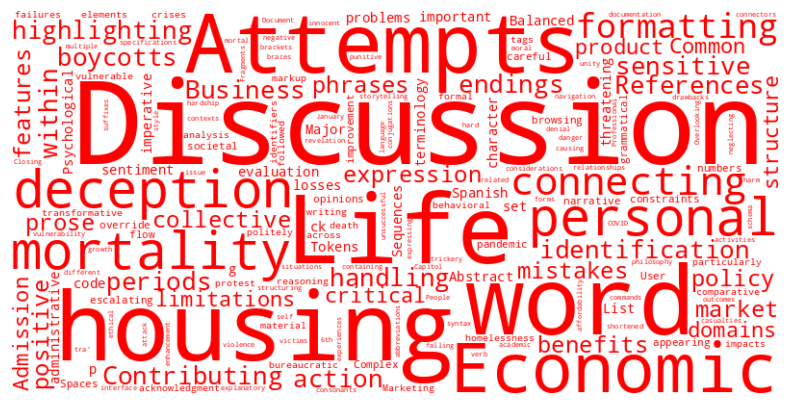

In [13]:
def generate_red_wordcloud(text, color="black"):
	wordcloud = WordCloud(
		width=800,
		height=400,
		background_color="white",  # White background
		color_func=lambda *args, **kwargs: color,  # All words in red
	).generate(text)

	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation="bilinear")
	plt.axis("off")  # Hide axes
	plt.show()

generate_red_wordcloud(combined_string_trump, "red")

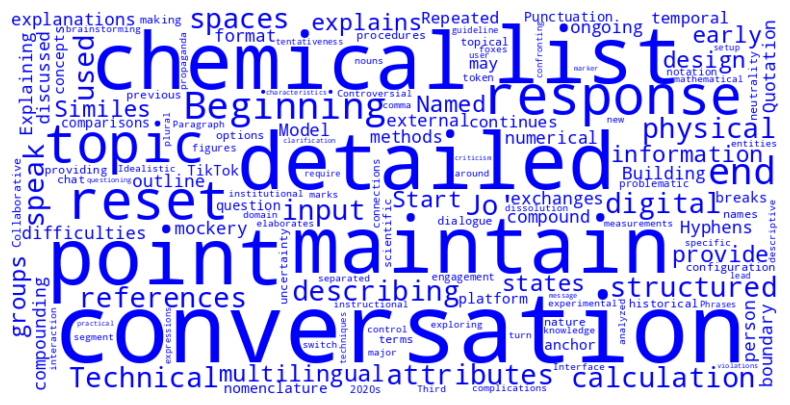

In [14]:
generate_red_wordcloud(combined_string_biden, "blue")


In [15]:
trump_conv = [
		[
			{
				"role": "user",
				"content": f"\"{text}\"",
			},
			{"role": "assistant", "content": "Trump"},
		]
		for text in trump[60:60 + FEATURE_COMPUTE_SIZE]["tweet"].tolist()
]

variant.reset()
context = client.features.inspect(
    messages=trump_conv[0],
    model=variant,
)

In [16]:
context

ContextInspector(
   <|begin_of_text|><|start_header_id|>system<|end_header_id|>
   
   Cutting Knowledge Date: December 2023
   Today Date: 26 Jul 2024
   
   <|eot_id|><|start_header_id|>user<|end_header_id|>
   
   "Once #Trump is re-elected the #media #fakenews #Msm #SocialMedia...
)

In [18]:
lookup =  context.top(k=10)
lookup

FeatureActivations(
   0: (Feature("Formal expression of controversial or critical opinions"), 42)
   1: (Feature("Interface and interaction design concepts"), 29)
   2: (Feature("Hashtags for nature, space and exploration photography on social media"), 19)
   3: (Feature("Enumerating implemented political policies and actions"), 18)
   4: (Feature("The assistant should write in Trump's speaking style"), 18)
   5: (Feature("Technical setup and configuration states in experimental procedures"), 14)
   6: (Feature("Complex academic prose and technical writing style"), 14)
   7: (Feature("Discussion of term limits and succession in positions of power"), 14)
   8: (Feature("Far-right extremist rhetoric and argumentative patterns"), 14)
   9: (Feature("Neutral biographical descriptions of Trump's presidency and controversies"), 11)
)